####import necessary modules

In [ ]:
! pip install keras_preprocessing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.7 MB/s eta 0:00:00


In [ ]:
import numpy as np
import keras
import tensorflow as tf
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Activation, BatchNormalization, UpSampling2D
from keras.models import Model
from keras.layers import Dropout,GlobalAveragePooling2D,LeakyReLU,Dense,Reshape, concatenate,Conv2DTranspose
from keras.models import Model,load_model
import matplotlib.pyplot as plt
import keras.backend as K



import os
import time
from datetime import datetime


from keras.applications import InceptionResNetV2
from keras.callbacks import TensorBoard

from keras.optimizers import Adam
from keras.utils import to_categorical
from keras_preprocessing import image

from numpy import asarray
from numpy import vstack
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from numpy import savez_compressed


import pandas as pd

import os

from matplotlib import pyplot

from numpy import load

from random import random
from numpy import load
from numpy import zeros
from numpy import ones
from numpy import asarray
from numpy.random import randint
from keras.optimizers import Adam




#### set tf backend config to allocate memory as needed instead of pre-allocating

In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K

# Allow GPU memory growth (TensorFlow 2.x)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)


1 Physical GPUs, 1 Logical GPUs


#### mount google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!ls -al '/content/drive/My Drive/face_aging/'

total 853380
-rw------- 1 root root 873860912 Jun 12 19:09 part1.tar.gz


In [ ]:
ls -al

total 20
drwxr-xr-x 1 root root 4096 Jun 16 12:55 ./
drwxr-xr-x 1 root root 4096 Jun 16 12:30 ../
drwxr-xr-x 4 root root 4096 Jun 13 13:27 .config/
drwx------ 5 root root 4096 Jun 16 12:53 drive/
drwxr-xr-x 1 root root 4096 Jun 13 13:28 sample_data/


#### get the UTKFace dataset

In [ ]:
!tar zxf '/content/drive/My Drive/face_aging/part1.tar.gz'


### Parse the data
####The labels of each face image is embedded in the file name, formated like [age]_[gender]_[race]_[date&time].jpg

    [age] is an integer from 0 to 116, indicating the age
    [gender] is either 0 (male) or 1 (female)
    [race] is an integer from 0 to 4, denoting White, Black, Asian, Indian, and Others (like Hispanic, Latino, Middle Eastern).
    [date&time] is in the format of yyyymmddHHMMSSFFF, showing the date and time an image was collected to UTKFace


In [ ]:


data=[]

for filename in os.listdir('./part1'):
  parts=filename.split('_')
  #print(parts[3])
  item={}
  item['image']=filename
  item['age']=parts[0]
  item['gender']=parts[1]
  item['race']=parts[2]
  if (len(parts)==4):
    item['date_time']=parts[3]
  data.append(item)

utk_data=pd.DataFrame(data)
utk_data.describe()

image    age gender   race  \
count                          10137  10137  10137  10137   
unique                         10137     99      3      7   
top     25_1_3_20170104222511735.jpg      1      1      0   
freq                               1   1271   5597   5396   

                    date_time  
count                   10135  
unique                  10064  
top     20170110173815028.jpg  
freq                        7

In [ ]:
utk_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10137 entries, 0 to 10136
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   image      10137 non-null  object
 1   age        10137 non-null  object
 2   gender     10137 non-null  object
 3   race       10137 non-null  object
 4   date_time  10135 non-null  object
dtypes: object(5)
memory usage: 396.1+ KB


In [ ]:
utk_data.head()

image age gender race              date_time
0  25_1_3_20170104222511735.jpg  25      1    3  20170104222511735.jpg
1  92_1_0_20170110182333823.jpg  92      1    0  20170110182333823.jpg
2  19_1_0_20170109193136416.jpg  19      1    0  20170109193136416.jpg
3  36_0_0_20170108225341913.jpg  36      0    0  20170108225341913.jpg
4  30_0_2_20161219190337805.jpg  30      0    2  20161219190337805.jpg

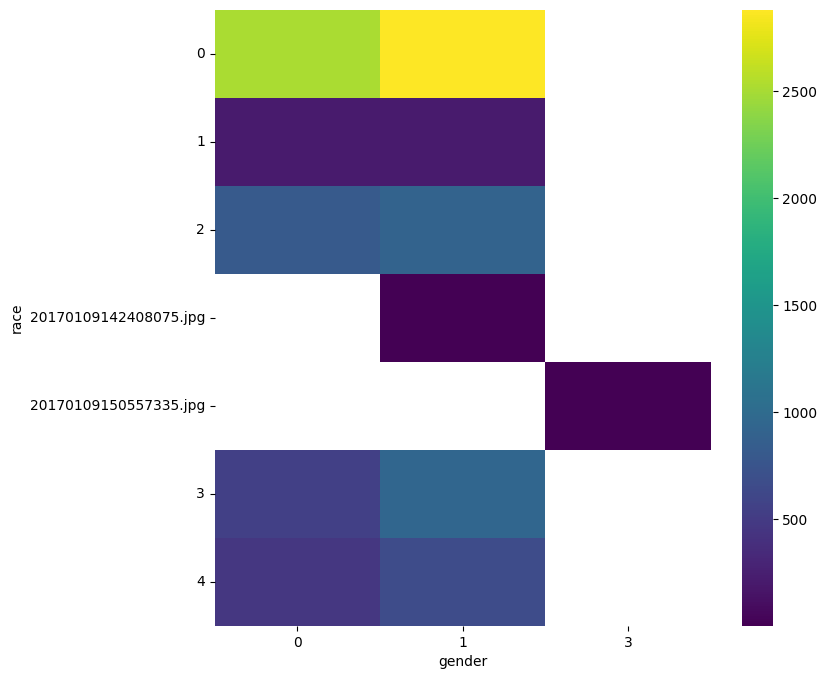

In [ ]:
# @title gender vs race

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['race'].value_counts()
    for x_label, grp in utk_data.groupby('gender')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('gender')
_ = plt.ylabel('race')

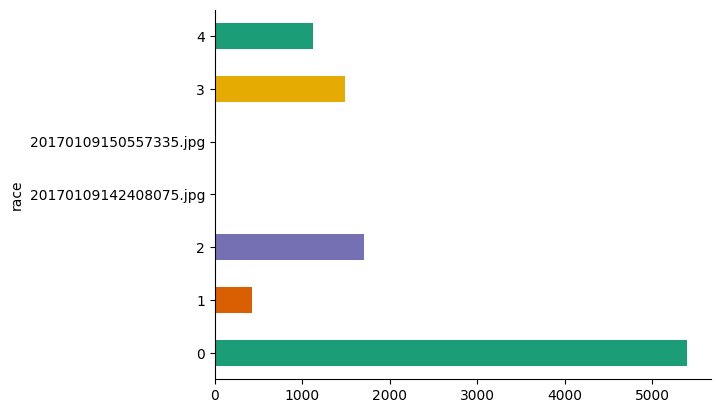

In [ ]:
# @title race

from matplotlib import pyplot as plt
import seaborn as sns
utk_data.groupby('race').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

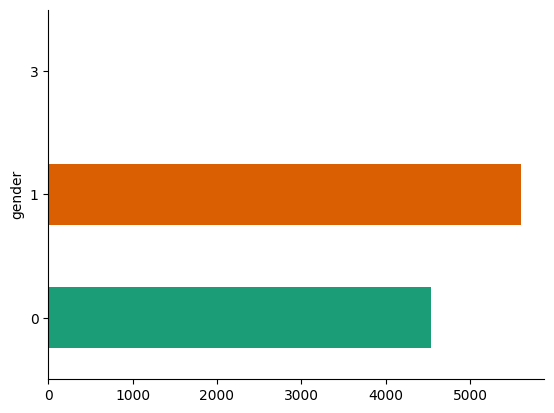

In [ ]:
# @title gender

from matplotlib import pyplot as plt
import seaborn as sns
utk_data.groupby('gender').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

#### we do not need date time , so delete it

In [ ]:
del utk_data['date_time']

#### define a category for ages and apply it to the dataset

In [ ]:
def age_cat_fn(age):
  age=int(age)

  if (0<age<18):
    return 0
  elif(18<=age<=25):
    return 1
  elif (25<age<=39):
    return 2
  elif (39< age <=49):
    return 3
  elif (49 < age <=60):
    return 4
  elif age>60:
    return 5


In [ ]:
utk_data['age_cat']=utk_data.age.map(age_cat_fn)

In [ ]:
!mkdir -p '/content/drive/My Drive/EIP3/session7'


In [ ]:
utk_data.to_csv('utk_data.csv',sep=',')
!cp 'utk_data.csv' '/content/drive/My Drive/EIP3/session7'


#### data with age category

In [ ]:
utk_data.head()

image age gender race  age_cat
0  25_1_3_20170104222511735.jpg  25      1    3        1
1  92_1_0_20170110182333823.jpg  92      1    0        5
2  19_1_0_20170109193136416.jpg  19      1    0        1
3  36_0_0_20170108225341913.jpg  36      0    0        2
4  30_0_2_20161219190337805.jpg  30      0    2        2

#### split our data into two Domains
1. Young : age category 1
2. Old : Age category 4

In [ ]:
data_A=utk_data[utk_data.age_cat==1]
data_B=utk_data[utk_data.age_cat==4]

In [ ]:
print(data_A['age_cat'].count())
print(data_B['age_cat'].count())

1063
1087


In [ ]:
import pandas as pd

import os

utk_data=pd.read_csv('/content/drive/My Drive/EIP3/session7/utk_data.csv')

#### get the iames belonging to the two Domains and save as a compressed numpy array so that we can load them when necesary instead of processing the UTKFace dataset multiple times

In [ ]:
image_dir='./part1/'


image_paths_A = data_A['image'].tolist()
image_paths_B = data_B['image'].tolist()

#print(image_paths[:10])



In [ ]:

images_A=None
images_B=None
#store 2000 images for A
for i, image_path in enumerate(image_paths_A):
  if (i<2000):
    if (i%1000==0):
      print("processing set A image num "+str(i))
    try:
      # Load image
      loaded_image = image.load_img(image_dir+image_path, target_size=(128,128,3))

      # Convert PIL image to numpy ndarray
      loaded_image = image.img_to_array(loaded_image)

      # Add another dimension (Add batch dimension)
      loaded_image = np.expand_dims(loaded_image, axis=0)

      # Concatenate all images into one tensor
      if images_A is None:
        images_A = loaded_image
      else:
        images_A = np.concatenate([images_A, loaded_image], axis=0)
    except Exception as e:
      print("Error:", i, e)

#store 2000 images for B
for i, image_path in enumerate(image_paths_B):
  if (i<2000):
    if (i%999==0):
      print("processing set B image num "+str(i))
    try:
      # Load image
      loaded_image = image.load_img(image_dir+image_path, target_size=(128,128,3))

      # Convert PIL image to numpy ndarray
      loaded_image = image.img_to_array(loaded_image)

      # Add another dimension (Add batch dimension)
      loaded_image = np.expand_dims(loaded_image, axis=0)

      # Concatenate all images into one tensor
      if images_B is None:
        images_B = loaded_image
      else:
        images_B = np.concatenate([images_B, loaded_image], axis=0)
    except Exception as e:
      print("Error:", i, e)


processing set A image num 0
processing set A image num 1000
processing set B image num 0
processing set B image num 999


In [ ]:
print('images_A :')
print(images_A.shape)
print('images_B :')
print(images_B.shape)

images_A :
(1063, 128, 128, 3)
images_B :
(1087, 128, 128, 3)


In [ ]:
# save as compressed numpy array
filename = '/content/drive/My Drive/EIP3/session7/utkface_128.npz'
savez_compressed(filename, images_A, images_B)
print('Saved dataset: ', filename)

Saved dataset:  /content/drive/My Drive/EIP3/session7/utkface_128.npz


#### load the saved numpy arrays and plot some images from either domain

Loaded:  (1063, 128, 128, 3) (1087, 128, 128, 3)


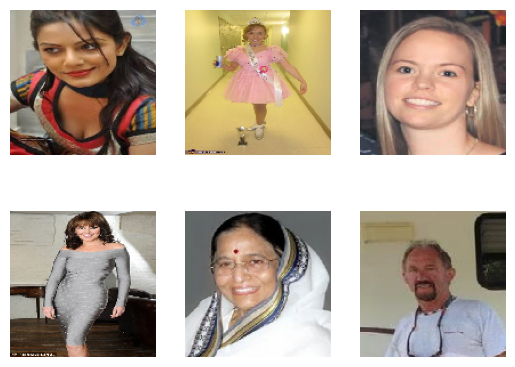

In [ ]:
from numpy import load
from matplotlib import pyplot
# load the dataset
data = load('/content/drive/My Drive/EIP3/session7/utkface_128.npz')
dataA, dataB = data['arr_0'], data['arr_1']
print('Loaded: ', dataA.shape, dataB.shape)
# plot source images
n_samples = 3
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + i)
	pyplot.axis('off')
	pyplot.imshow(dataA[i].astype('uint8'))
# plot target image
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + n_samples + i)
	pyplot.axis('off')
	pyplot.imshow(dataB[i].astype('uint8'))
pyplot.show()

#### install keras-contrib so that we can use InstanceNormalization instead of BatchNormalization

In [ ]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git


  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-cgi0bwo5
  Running command git clone --filter=blob:none --quiet https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-cgi0bwo5
  Resolved https://www.github.com/keras-team/keras-contrib.git to commit 3fc5ef709e061416f4bc8a92ca3750c824b5d2b0
  Preparing metadata (setup.py) ... done


In [ ]:
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from keras.initializers import RandomNormal

#### define helper functions for the various components of the Model that we are going to build

#### Conv layers

In [ ]:
# Convolutional layer
def conv2d(input_, output_dim, ks=4, s=2, stddev=0.02, padding='SAME', name='c2d'):
    return Conv2D(output_dim,
                  kernel_size=ks,
                  strides=s,
                  padding=padding,
                  kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=stddev),
                  name=name)(input_)

#### Leaky Relu

In [ ]:
def lrelu(input_,name='lr'):
  return LeakyReLU(alpha=0.2,name=name)(input_)



```
# This is formatted as code
```

#### Batch Normalization

In [ ]:
def iNorm(input_,name='iNorm'):
  return InstanceNormalization(axis=-1,name=name)(input_)

###Discriminator Model

In [ ]:
import tensorflow as tf
from keras.layers import Conv2D, LeakyReLU, Input
from keras.models import Model
from keras.optimizers import Adam
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
# discriminator model
def build_discriminator(image_shape):
  # weight initialization
	#init = RandomNormal(stddev=0.02)
	# source image input
	in_image = Input(shape=image_shape)
	#C1
	d1 = lrelu(conv2d(in_image,64,4,name='d_c1'),'lr1' )

	# C2
	d2 = lrelu(iNorm(conv2d(d1,128,4,name='d_c2'),'iN2'),'lr2')

	# C3
	d3 = lrelu(iNorm(conv2d(d1,256,4,name='d_c3'),'iN3'),'lr3')

	# C4
	d4 = lrelu(iNorm(conv2d(d3,512,4,name='d_c4'),'iN4'),'lr4')

	'''
	# second last output layer
	d = conv2d(in_image,128,3,1)
	d = iNorm(d)
	d = lrelu(d)
	'''

	#  output

	d5 = conv2d(d4,1,4,1,name='d_c5')  #Conv2D(1, 4,1, padding='same', kernel_initializer=init)(d)
	# define model
	model = Model(in_image, d5)
	# compile model
	model.compile(loss='mse', optimizer=Adam(lr=0.0002, beta_1=0.5), loss_weights=[0.5])
	return model

In [ ]:
disc=build_discriminator(dataB[0].shape)
disc.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 d_c1 (Conv2D)               (None, 64, 64, 64)        3136      
                                                                 
 lr1 (LeakyReLU)             (None, 64, 64, 64)        0         
                                                                 
 d_c3 (Conv2D)               (None, 32, 32, 256)       262400    
                                                                 
 iN3 (InstanceNormalization  (None, 32, 32, 256)       512       
 )                                                               
                                                                 
 lr3 (LeakyReLU)             (None, 32, 32, 256)       0         
                                                             

##### function to add padding

In [ ]:
def padd3(input_):
  import tensorflow as tf
  return tf.pad(input_, [[0, 0], [3, 3], [3, 3], [0, 0]], "REFLECT")

def padd1(input_):
  import tensorflow as tf
  return tf.pad(input_, [[0, 0], [1, 1], [1, 1], [0, 0]], "REFLECT")

#### The generator uses Resnet Blocks , as defined below

In [ ]:
from keras.layers import Add,Lambda
def res_block(input_,nf=64,ks=3,s=1,name='res_blk'):
  p=int((ks-1)/2)
  y=Lambda(padd1)(input_) #(tf.pad(input_,[[0,0],[p,p],[p,p],[0,0]],'REFLECT'))

  y=iNorm(conv2d(y,nf,ks,s,padding='VALID',name=name+'_c1'),name=name+'_iN1')

  y=Lambda(padd1)(y) #(tf.pad(tf.nn.relu(y),[[0,0],[p,p],[p,p],[0,0]],'REFLECT'))

  y=iNorm(conv2d(y,nf,ks,s,padding='VALID',name=name+'_c2'),name=name+'_iN2')


  y1=keras.layers.Add()([y,input_])

  return y1


#### deconvolution layers

In [ ]:
import tensorflow as tf
from keras.layers import Add, Lambda, Conv2D, LeakyReLU, Input, Conv2DTranspose, Activation
from keras.models import Model
from keras.optimizers import Adam
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization

def deconv2d(input_, output_dim, ks=4, s=2, stddev=0.02, padding='SAME', name='dc2d'):
    return Conv2DTranspose(output_dim,
                           (ks, ks),
                           strides=(s, s),
                           padding=padding,
                           kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=stddev),
                           name=name)(input_)


#### generator model

In [ ]:
from keras.layers import Lambda, Conv2DTranspose

def build_generator(image_shape):
    nf = 64  # num filters for first layer
    input_ = Input(shape=(128, 128, 3))
    c0 = Lambda(padd3)(input_)

    c1 = Activation('relu')(iNorm(conv2d(c0, nf, 7, 1, padding='VALID', name='g_e1_c'), 'g_e1_bn'))
    c2 = Activation('relu')(iNorm(conv2d(c1, nf*2, 3, 2, name='g_e2_c'), 'g_e2_bn'))
    c3 = Activation('relu')(iNorm(conv2d(c2, nf*4, 3, 2, name='g_e3_c'), 'g_e3_bn'))

    r1 = res_block(c3, nf*4, name='g_r1')
    r2 = res_block(r1, nf*4, name='g_r2')
    r3 = res_block(r2, nf*4, name='g_r3')
    r4 = res_block(r3, nf*4, name='g_r4')
    r5 = res_block(r4, nf*4, name='g_r5')
    r6 = res_block(r5, nf*4, name='g_r6')
    r7 = res_block(r6, nf*4, name='g_r7')
    r8 = res_block(r7, nf*4, name='g_r8')
    r9 = res_block(r8, nf*4, name='g_r9')

    d1 = Conv2DTranspose(nf*2, (3, 3), strides=(2, 2), padding='same', kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.02), name='g_d1_dc')(r9)
    d1 = Activation('relu')(iNorm(d1, name='g_d1_bn'))

    d2 = Conv2DTranspose(nf, (3, 3), strides=(2, 2), padding='same', kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.02), name='g_d2_dc')(d1)
    d2 = Activation('relu')(iNorm(d2, name='g_d2_bn'))

    d2 = Lambda(padd3)(d2)

    d3 = conv2d(d2, 3, 7, 1, padding='VALID', name='g_pred_c')

    pred = Activation('tanh')(d3)

    model = Model(input_, pred)

    return model

In [ ]:
gen=build_generator(dataA[0].shape)
gen.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 lambda (Lambda)             (None, 134, 134, 3)          0         ['input_2[0][0]']             
                                                                                                  
 g_e1_c (Conv2D)             (None, 128, 128, 64)         9472      ['lambda[0][0]']              
                                                                                                  
 g_e1_bn (InstanceNormaliza  (None, 128, 128, 64)         128       ['g_e1_c[0][0]']              
 tion)                                                                                      

####composite Model with two genartors and discriminator

In [ ]:
def build_composite_model(g_model_1, d_model, g_model_2, image_shape):
	# ensure the model we're updating is trainable
	g_model_1.trainable = True
	# mark discriminator as not trainable
	d_model.trainable = False
	# mark other generator model as not trainable
	g_model_2.trainable = False
	# discriminator element
	input_gen = Input(shape=image_shape)
	gen1_out = g_model_1(input_gen)
	output_d = d_model(gen1_out)
	# identity element
	input_id = Input(shape=image_shape)
	output_id = g_model_1(input_id)
	# forward cycle
	output_f = g_model_2(gen1_out)
	# backward cycle
	gen2_out = g_model_2(input_id)
	output_b = g_model_1(gen2_out)
	# define model graph
	model = Model([input_gen, input_id], [output_d, output_id, output_f, output_b])
	# define optimization algorithm configuration
	opt = Adam(lr=0.0002, beta_1=0.5)
	# compile model with weighting of least squares loss and L1 loss
	model.compile(loss=['mse', 'mae', 'mae', 'mae'], loss_weights=[1, 5, 10, 10], optimizer=opt)
	return model

### The original samples are over 3100 per domain and it is increasing the time for each epoch(has proven problematic in the initial training runs). So we will use a function to get a subsample of the training data , 1000 per Domain  

In [ ]:
def get_subsample(dataset):

    t1=np.random.randint(900)
    t2=np.random.randint(1200,2000)
    t3=np.random.randint(2500,2800)
    return np.vstack((dataset[0][t1:t1+300],dataset[0][t2:t2+400],dataset[0][t3:t3+300])),np.vstack((dataset[1][t1:t1+300], dataset[1][t2:t2+400],dataset[1][t3:t3+300]))



In [ ]:
def get_subsample2(dataset):
  t0=np.random.randint(250)
  t1=np.random.randint(300)
  t2=np.random.randint(1200,2000)
  t3=np.random.randint(2500,2800)
  return np.vstack((dataset[0][t1:t1+800],dataset[0][t2:t2+200])),np.vstack((dataset[1][t1:t1+100], dataset[2][t0:t0+900]))


#### Utility Functions to load the image samples , generate fake images , save Models , Save genrated images , etc

In [ ]:
def load_real_samples2(filename):
  data = load(filename)
  X1,X2,X3 = data['arr_0'],data['arr_1'],data['arr_2']
  X1= (X1-127.5)/127.5
  X2 = (X2-127.5)/127.5
  X3 = (X3-127.5)/127.5
  return X1,X2,X3

In [ ]:
# load and prepare training images
def load_real_samples(filename):
	# load the dataset
	data = load(filename)
	# unpack arrays
	X1, X2 = data['arr_0'], data['arr_1']
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, patch_shape, patch_shape, 1))
	return X, y

# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, dataset, patch_shape):
	# generate fake instance
	X = g_model.predict(dataset)
	# create 'fake' class labels (0)
	y = zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

# save the generator models to file
def save_models(step, g_model_AtoB, g_model_BtoA):
	# save the first generator model
	filename1 = '/content/drive/My Drive/EIP3/session7/g_model_AtoB_%06d.h5' % (step+1)
	g_model_AtoB.save(filename1)
	# save the second generator model
	filename2 = '/content/drive/My Drive/EIP3/session7/g_model_BtoA_%06d.h5' % (step+1)
	g_model_BtoA.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))

# save the generator models to file
def save_models2(step, g_model_AtoB, g_model_BtoA,d_model_A,d_model_B):
	# save the first generator model
	filename1 = '/content/drive/My Drive/EIP3/session7/g_model_AtoB_%06d.h5' % (step+1)
	g_model_AtoB.save(filename1)
	# save the second generator model
	filename2 = '/content/drive/My Drive/EIP3/session7/g_model_BtoA_%06d.h5' % (step+1)
	g_model_BtoA.save(filename2)
  # save the first discriminator model A
	filename3 = '/content/drive/My Drive/EIP3/session7/d_model_A_%06d.h5' % (step+1)
	d_model_A.save(filename3)
  # save the first discriminator model B
	filename4 = '/content/drive/My Drive/EIP3/session7/d_model_B_%06d.h5' % (step+1)
	d_model_B.save(filename4)
	print('>Saved: %s , %s , %s and %s' % (filename1, filename2,filename3,filename4))


In [ ]:
# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, trainX, name, n_samples=5):

	pyplot.figure(
    figsize=(15, 8),
    dpi=120)

	# select a sample of input images
	X_in, _ = generate_real_samples(trainX, n_samples, 0)
	# generate translated images
	X_out, _ = generate_fake_samples(g_model, X_in, 0)
	# scale all pixels from [-1,1] to [0,1]
	X_in = (X_in + 1) / 2.0
	X_out = (X_out + 1) / 2.0
	# plot real images
	for i in range(n_samples):
		pyplot.subplot(2, n_samples, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(X_in[i])
	# plot translated image
	for i in range(n_samples):
		pyplot.subplot(2, n_samples, 1 + n_samples + i)
		pyplot.axis('off')
		pyplot.imshow(X_out[i])
	# save plot to file
	filename1 = '/content/drive/My Drive/EIP3/session7/%s_generated_plot_%06d.png' % (name, (step+1))
	pyplot.savefig(filename1)
	pyplot.close()

#### Maintain a pool of 50 images as described in the paper

In [ ]:
# update image pool for fake images
def update_image_pool(pool, images, max_size=50):
	selected = list()
	for image in images:
		if len(pool) < max_size:
			# stock the pool
			pool.append(image)
			selected.append(image)
		elif random() < 0.5:
			# use image, but don't add it to the pool
			selected.append(image)
		else:
			# replace an existing image and use replaced image
			ix = randint(0, len(pool))
			selected.append(pool[ix])
			pool[ix] = image
	return asarray(selected)

#### function to run the training

In [ ]:
# train cyclegan models
def train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset,batch_size,n_epochs):
	# define properties of the training run
	n_epochs, n_batch, = n_epochs, batch_size
	# determine the output square shape of the discriminator
	n_patch = d_model_A.output_shape[1]
	# unpack dataset
	trainA, trainB = get_subsample(dataset)
	# prepare image pool for fakes
	poolA, poolB = list(), list()
	# calculate the number of batches per training epoch
	bat_per_epo = int(len(trainA) / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	# manually enumerate epochs
	for i in range(n_steps):
		# select a batch of real samples
		X_realA, y_realA = generate_real_samples(trainA, n_batch, n_patch)
		X_realB, y_realB = generate_real_samples(trainB, n_batch, n_patch)
		# generate a batch of fake samples
		X_fakeA, y_fakeA = generate_fake_samples(g_model_BtoA, X_realB, n_patch)
		X_fakeB, y_fakeB = generate_fake_samples(g_model_AtoB, X_realA, n_patch)
		# update fakes from pool
		X_fakeA = update_image_pool(poolA, X_fakeA)
		X_fakeB = update_image_pool(poolB, X_fakeB)
		# update generator B->A via adversarial and cycle loss
		g_loss2, _, _, _, _  = c_model_BtoA.train_on_batch([X_realB, X_realA], [y_realA, X_realA, X_realB, X_realA])
		# update discriminator for A -> [real/fake]
		dA_loss1 = d_model_A.train_on_batch(X_realA, y_realA)
		dA_loss2 = d_model_A.train_on_batch(X_fakeA, y_fakeA)
		# update generator A->B via adversarial and cycle loss
		g_loss1, _, _, _, _ = c_model_AtoB.train_on_batch([X_realA, X_realB], [y_realB, X_realB, X_realA, X_realB])
		# update discriminator for B -> [real/fake]
		dB_loss1 = d_model_B.train_on_batch(X_realB, y_realB)
		dB_loss2 = d_model_B.train_on_batch(X_fakeB, y_fakeB)
		# summarize performance
		print('>%d, dA[%.3f,%.3f] dB[%.3f,%.3f] g[%.3f,%.3f]' % (i+1, dA_loss1,dA_loss2, dB_loss1,dB_loss2, g_loss1,g_loss2))
		# evaluate the model performance every so often
		if (i+1) % (bat_per_epo * 1) == 0:
			# plot A->B translation
			summarize_performance(i, g_model_AtoB, trainA, 'AtoB')
			# plot B->A translation
			summarize_performance(i, g_model_BtoA, trainB, 'BtoA')
		if (i+1) % (bat_per_epo * 5) == 0:
			# save the models
			save_models2(i, g_model_AtoB, g_model_BtoA,d_model_A,d_model_B)

#### define the models and run training

In [ ]:
from random import random
from numpy import load
from numpy import zeros
from numpy import ones
from numpy import asarray
from numpy.random import randint
from keras.optimizers import Adam
# load image data
dataset = load_real_samples('/content/drive/My Drive/EIP3/session7/utkface_128.npz')
print('Loaded', dataset[0].shape, dataset[1].shape)
# define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]
# generator: A -> B
g_model_AtoB = build_generator(image_shape)
# generator: B -> A
g_model_BtoA = build_generator(image_shape)
# discriminator: A -> [real/fake]
d_model_A = build_discriminator(image_shape)
# discriminator: B -> [real/fake]
d_model_B = build_discriminator(image_shape)
# composite: A -> B -> [real/fake, A]
c_model_AtoB = build_composite_model(g_model_AtoB, d_model_B, g_model_BtoA, image_shape)
# composite: B -> A -> [real/fake, B]
c_model_BtoA = build_composite_model(g_model_BtoA, d_model_A, g_model_AtoB, image_shape)
# train models
train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset,batch_size=2,n_epochs=10)

Loaded (1063, 128, 128, 3) (1087, 128, 128, 3)


1/1 [==============================] - 1s 726ms/step


>1, dA[1.136,4.507] dB[1.200,8.162] g[17.353,17.798]
1/1 [==============================] - 0s 20ms/step
>2, dA[23.897,19.923] dB[11.733,23.830] g[42.603,28.185]
1/1 [==============================] - 0s 19ms/step
>3, dA[8.072,10.879] dB[3.870,2.716] g[27.079,30.591]
1/1 [==============================] - 0s 20ms/step
>4, dA[4.041,7.088] dB[1.501,0.944] g[21.665,36.284]
1/1 [==============================] - 0s 19ms/step
>5, dA[2.379,2.169] dB[0.387,0.600] g[21.520,21.979]
1/1 [==============================] - 0s 20ms/step
>6, dA[0.698,0.406] dB[0.249,0.396] g[17.077,17.481]
1/1 [==============================] - 0s 19ms/step
>7, dA[0.387,0.271] dB[0.354,0.372] g[16.308,17.625]
1/1 [==============================] - 0s 21ms/step
>8, dA[0.320,0.244] dB[0.290,0.671] g[16.770,16.861]
1/1 [==============================] - 0s 20ms/step
>9, dA[0.220,0.186] dB[0.288,1.038] g[18.342,19.298]
1/1 [==============================] - 0s 33ms/step
>10, dA[0.242,0.179] dB[0.409,0.950] g[13.633,13.2

>Saved: /content/drive/My Drive/EIP3/session7/g_model_AtoB_000750.h5 , /content/drive/My Drive/EIP3/session7/g_model_BtoA_000750.h5 , /content/drive/My Drive/EIP3/session7/d_model_A_000750.h5 and /content/drive/My Drive/EIP3/session7/d_model_B_000750.h5
1/1 [==============================] - 0s 21ms/step
>751, dA[0.350,0.152] dB[0.172,0.239] g[5.332,6.580]
1/1 [==============================] - 0s 21ms/step
>752, dA[0.094,0.270] dB[0.258,0.153] g[5.103,5.248]
1/1 [==============================] - 0s 22ms/step
>753, dA[0.266,0.269] dB[0.164,0.240] g[5.152,6.648]
1/1 [==============================] - 0s 21ms/step
>754, dA[0.238,0.141] dB[0.195,0.170] g[6.789,7.509]
1/1 [==============================] - 0s 22ms/step
>755, dA[0.291,0.310] dB[0.259,0.251] g[5.878,5.267]
1/1 [==============================] - 0s 20ms/step
>756, dA[0.219,0.152] dB[0.164,0.238] g[6.246,7.159]
1/1 [==============================] - 0s 20ms/step
>757, dA[0.300,0.199] dB[0.230,0.218] g[5.411,5.996]
1/1 [======

>Saved: /content/drive/My Drive/EIP3/session7/g_model_AtoB_001500.h5 , /content/drive/My Drive/EIP3/session7/g_model_BtoA_001500.h5 , /content/drive/My Drive/EIP3/session7/d_model_A_001500.h5 and /content/drive/My Drive/EIP3/session7/d_model_B_001500.h5


In [ ]:
import os

# Directory where models are saved
directory = '/content/drive/My Drive/EIP3/session7/'

# List all files in the directory
files = os.listdir(directory)

# Filter only .h5 files (model files)
model_files = [f for f in files if f.endswith('.h5')]

# Sort the files by modification time
model_files.sort(key=lambda x: os.path.getmtime(os.path.join(directory, x)), reverse=True)

# Print the files
for f in model_files:
    print(f)


d_model_B_000060.h5
d_model_A_000060.h5
g_model_BtoA_000060.h5
g_model_AtoB_000060.h5
d_model_B_000480.h5
g_model_BtoA_000480.h5
d_model_A_000480.h5
g_model_AtoB_000480.h5
d_model_A_000420.h5
d_model_B_000420.h5
g_model_AtoB_000420.h5
g_model_BtoA_000420.h5
d_model_A_000360.h5
d_model_B_000360.h5
g_model_BtoA_000360.h5
g_model_AtoB_000360.h5
d_model_B_000300.h5
d_model_A_000300.h5
g_model_AtoB_000300.h5
g_model_BtoA_000300.h5
d_model_B_000240.h5
d_model_A_000240.h5
g_model_BtoA_000240.h5
g_model_AtoB_000240.h5
d_model_B_000180.h5
d_model_A_000180.h5
g_model_BtoA_000180.h5
g_model_AtoB_000180.h5
d_model_B_000120.h5
d_model_A_000120.h5
g_model_AtoB_000120.h5
g_model_BtoA_000120.h5
d_model_B_000315.h5
d_model_A_000315.h5
g_model_BtoA_000315.h5
g_model_AtoB_000315.h5
d_model_B_000270.h5
d_model_A_000270.h5
g_model_AtoB_000270.h5
g_model_BtoA_000270.h5
g_model_BtoA_000225.h5
d_model_A_000225.h5
d_model_B_000225.h5
g_model_AtoB_000225.h5
d_model_A_000135.h5
d_model_B_000135.h5
g_model_AtoB_0

In [ ]:
import os

# Assuming model_files is a list of filenames sorted by name
model_files = [
    'd_model_B_000060.h5', 'd_model_A_000060.h5', 'g_model_BtoA_000060.h5', 'g_model_AtoB_000060.h5',
    'd_model_B_000480.h5', 'g_model_BtoA_000480.h5', 'd_model_A_000480.h5', 'g_model_AtoB_000480.h5',
    'd_model_A_000420.h5', 'd_model_B_000420.h5', 'g_model_AtoB_000420.h5', 'g_model_BtoA_000420.h5',
    'd_model_A_000360.h5', 'd_model_B_000360.h5', 'g_model_BtoA_000360.h5', 'g_model_AtoB_000360.h5',
    'd_model_B_000300.h5', 'd_model_A_000300.h5', 'g_model_AtoB_000300.h5', 'g_model_BtoA_000300.h5',
    'd_model_B_000240.h5', 'd_model_A_000240.h5', 'g_model_BtoA_000240.h5', 'g_model_AtoB_000240.h5',
    'd_model_B_000180.h5', 'd_model_A_000180.h5', 'g_model_BtoA_000180.h5', 'g_model_AtoB_000180.h5',
    'd_model_B_000120.h5', 'd_model_A_000120.h5', 'g_model_AtoB_000120.h5', 'g_model_BtoA_000120.h5',
    'd_model_B_000315.h5', 'd_model_A_000315.h5', 'g_model_BtoA_000315.h5', 'g_model_AtoB_000315.h5',
    'd_model_B_000270.h5', 'd_model_A_000270.h5', 'g_model_AtoB_000270.h5', 'g_model_BtoA_000270.h5',
    'g_model_BtoA_000225.h5', 'd_model_A_000225.h5', 'd_model_B_000225.h5', 'g_model_AtoB_000225.h5',
    'd_model_A_000135.h5', 'd_model_B_000135.h5', 'g_model_AtoB_000135.h5', 'g_model_BtoA_000135.h5',
    'g_model_BtoA_000090.h5', 'd_model_A_000090.h5', 'd_model_B_000090.h5', 'g_model_AtoB_000090.h5',
    'd_model_B_000045.h5', 'g_model_AtoB_000045.h5', 'g_model_BtoA_000045.h5', 'd_model_A_000045.h5',
    'd_model_A_001500.h5', 'd_model_B_001500.h5', 'g_model_AtoB_001500.h5', 'g_model_BtoA_001500.h5',
    'd_model_A_000750.h5', 'g_model_BtoA_000750.h5', 'g_model_AtoB_000750.h5', 'd_model_B_000750.h5'
]

# Sort model files by name (assuming they are already sorted)
model_files.sort()

# Check if there are at least two model files
if len(model_files) >= 2:
    # Get the paths of the latest models
    latest_g_model_AtoB = os.path.join(directory, model_files[-1])
    latest_g_model_BtoA = os.path.join(directory, model_files[-2])

    # Print the paths of the latest models
    print(f"Latest g_model_AtoB: {latest_g_model_AtoB}")
    print(f"Latest g_model_BtoA: {latest_g_model_BtoA}")
else:
    print("Not enough model files found.")


Latest g_model_AtoB: /content/drive/My Drive/EIP3/session7/g_model_BtoA_001500.h5
Latest g_model_BtoA: /content/drive/My Drive/EIP3/session7/g_model_BtoA_000750.h5


In [ ]:
from numpy import load

# Load image data
dataset = load_real_samples('/content/drive/My Drive/EIP3/session7/utkface_128.npz')
print('Loaded', dataset[0].shape, dataset[1].shape)

# Check individual shapes
print('Dataset A shape:', dataset[0].shape)  # Should be (1063, 128, 128, 3) for RGB images
print('Dataset B shape:', dataset[1].shape)  # Should be (1087, 128, 128, 3) for RGB images


Loaded (1063, 128, 128, 3) (1087, 128, 128, 3)
Dataset A shape: (1063, 128, 128, 3)
Dataset B shape: (1087, 128, 128, 3)


In [ ]:

# load image data
dataset = load_real_samples('/content/drive/My Drive/EIP3/session7/utkface_128.npz')
print('Loaded', dataset[0].shape, dataset[1].shape)
# define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]

#load the previously trained model

cust = {'InstanceNormalization': InstanceNormalization, 'tf': tf}
# generator: A -> B
g_model_AtoB = load_model('/content/drive/My Drive/EIP3/session7/g_model_AtoB_000480.h5', cust)
# generator: B -> A
g_model_BtoA = load_model('/content/drive/My Drive/EIP3/session7/g_model_BtoA_000480.h5', cust)

# discriminator: A -> [real/fake]
d_model_A = build_discriminator(image_shape)
# discriminator: B -> [real/fake]
d_model_B = build_discriminator(image_shape)
# composite: A -> B -> [real/fake, A]
c_model_AtoB = build_composite_model(g_model_AtoB, d_model_B, g_model_BtoA, image_shape)
# composite: B -> A -> [real/fake, B]
c_model_BtoA = build_composite_model(g_model_BtoA, d_model_A, g_model_AtoB, image_shape)

Loaded (1063, 128, 128, 3) (1087, 128, 128, 3)


###Run time disconnected and session ended , so load last saved models and continue training . Increase the batch size and reduce the sample size too with get_subsample utility function

In [ ]:
train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset,batch_size=24,n_epochs=5)

1/1 [==============================] - 1s 730ms/step


1/1 [==============================] - 1s 765ms/step
>1, dA[0.985,26.476] dB[1.411,32.505] g[9.292,6.400]
1/1 [==============================] - 0s 26ms/step
>2, dA[15.522,3.019] dB[19.121,1.905] g[46.572,37.025]
1/1 [==============================] - 0s 23ms/step
>3, dA[0.695,0.366] dB[1.282,0.357] g[16.662,15.229]
1/1 [==============================] - 0s 45ms/step
>4, dA[0.626,0.136] dB[0.531,0.151] g[10.560,11.217]
1/1 [==============================] - 0s 25ms/step
>5, dA[0.270,0.298] dB[0.291,0.211] g[7.768,8.241]
1/1 [==============================] - 0s 25ms/step
>6, dA[0.186,0.225] dB[0.200,0.238] g[7.224,7.437]
1/1 [==============================] - 0s 43ms/step
>7, dA[0.253,0.178] dB[0.198,0.199] g[6.917,7.349]
1/1 [==============================] - 0s 23ms/step
>8, dA[0.238,0.200] dB[0.238,0.201] g[5.836,6.458]
1/1 [==============================] - 0s 25ms/step
>9, dA[0.217,0.224] dB[0.214,0.208] g[7.061,6.326]
1/1 [==============================] - 0s 38ms/step
>10, dA[0.

>Saved: /content/drive/My Drive/EIP3/session7/g_model_AtoB_000060.h5 , /content/drive/My Drive/EIP3/session7/g_model_BtoA_000060.h5 , /content/drive/My Drive/EIP3/session7/d_model_A_000060.h5 and /content/drive/My Drive/EIP3/session7/d_model_B_000060.h5


In [ ]:
train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset,batch_size=24,n_epochs=20)

1/1 [==============================] - 0s 36ms/step
>1, dA[0.332,0.334] dB[0.315,0.324] g[5.847,6.173]
1/1 [==============================] - 0s 23ms/step
>2, dA[0.300,0.320] dB[0.362,0.355] g[5.474,5.846]
1/1 [==============================] - 0s 31ms/step
>3, dA[0.303,0.304] dB[0.339,0.306] g[6.009,6.242]
1/1 [==============================] - 0s 34ms/step
>4, dA[0.313,0.353] dB[0.322,0.335] g[5.356,5.604]
1/1 [==============================] - 0s 23ms/step
>5, dA[0.357,0.310] dB[0.328,0.276] g[5.424,5.680]
1/1 [==============================] - 0s 25ms/step
>6, dA[0.314,0.337] dB[0.296,0.313] g[5.228,5.981]
1/1 [==============================] - 0s 40ms/step
>7, dA[0.343,0.355] dB[0.324,0.319] g[5.373,5.561]
1/1 [==============================] - 0s 24ms/step
>8, dA[0.354,0.307] dB[0.311,0.343] g[5.501,5.794]
1/1 [==============================] - 0s 24ms/step
>9, dA[0.274,0.345] dB[0.322,0.293] g[5.195,5.461]
1/1 [==============================] - 0s 35ms/step
>10, dA[0.347,0.327] 

>Saved: /content/drive/My Drive/EIP3/session7/g_model_AtoB_000060.h5 , /content/drive/My Drive/EIP3/session7/g_model_BtoA_000060.h5 , /content/drive/My Drive/EIP3/session7/d_model_A_000060.h5 and /content/drive/My Drive/EIP3/session7/d_model_B_000060.h5
1/1 [==============================] - 0s 24ms/step
>61, dA[0.348,0.309] dB[0.324,0.308] g[4.992,5.659]
1/1 [==============================] - 0s 55ms/step
>62, dA[0.315,0.310] dB[0.326,0.298] g[4.905,5.186]
1/1 [==============================] - 0s 23ms/step
>63, dA[0.295,0.314] dB[0.295,0.313] g[5.617,5.799]
1/1 [==============================] - 0s 24ms/step
>64, dA[0.335,0.354] dB[0.387,0.321] g[5.890,5.888]
1/1 [==============================] - 0s 35ms/step
>65, dA[0.323,0.283] dB[0.254,0.278] g[5.385,5.934]
1/1 [==============================] - 0s 26ms/step
>66, dA[0.288,0.293] dB[0.308,0.249] g[5.457,6.308]
1/1 [==============================] - 0s 39ms/step
>67, dA[0.303,0.329] dB[0.265,0.338] g[5.144,5.467]
1/1 [=============

>Saved: /content/drive/My Drive/EIP3/session7/g_model_AtoB_000120.h5 , /content/drive/My Drive/EIP3/session7/g_model_BtoA_000120.h5 , /content/drive/My Drive/EIP3/session7/d_model_A_000120.h5 and /content/drive/My Drive/EIP3/session7/d_model_B_000120.h5
1/1 [==============================] - 0s 24ms/step
>121, dA[0.351,0.315] dB[0.291,0.301] g[5.249,6.152]
1/1 [==============================] - 0s 23ms/step
>122, dA[0.308,0.295] dB[0.303,0.277] g[5.018,5.327]
1/1 [==============================] - 0s 48ms/step
>123, dA[0.279,0.277] dB[0.276,0.288] g[5.116,5.173]
1/1 [==============================] - 0s 42ms/step
>124, dA[0.265,0.258] dB[0.298,0.269] g[5.328,5.472]
1/1 [==============================] - 0s 37ms/step
>125, dA[0.267,0.288] dB[0.315,0.314] g[4.804,5.094]
1/1 [==============================] - 0s 24ms/step
>126, dA[0.262,0.253] dB[0.288,0.267] g[5.155,5.196]
1/1 [==============================] - 0s 23ms/step
>127, dA[0.295,0.299] dB[0.269,0.263] g[4.939,4.957]
1/1 [======

>Saved: /content/drive/My Drive/EIP3/session7/g_model_AtoB_000180.h5 , /content/drive/My Drive/EIP3/session7/g_model_BtoA_000180.h5 , /content/drive/My Drive/EIP3/session7/d_model_A_000180.h5 and /content/drive/My Drive/EIP3/session7/d_model_B_000180.h5
1/1 [==============================] - 0s 39ms/step
>181, dA[0.244,0.275] dB[0.280,0.226] g[4.856,5.221]
1/1 [==============================] - 0s 24ms/step
>182, dA[0.315,0.262] dB[0.237,0.252] g[5.126,6.254]
1/1 [==============================] - 0s 26ms/step
>183, dA[0.261,0.285] dB[0.252,0.248] g[4.655,4.840]
1/1 [==============================] - 0s 39ms/step
>184, dA[0.246,0.232] dB[0.297,0.296] g[4.736,4.891]
1/1 [==============================] - 0s 23ms/step
>185, dA[0.250,0.309] dB[0.273,0.247] g[4.855,4.943]
1/1 [==============================] - 0s 32ms/step
>186, dA[0.329,0.330] dB[0.295,0.270] g[4.685,5.296]
1/1 [==============================] - 0s 24ms/step
>187, dA[0.367,0.319] dB[0.236,0.259] g[5.124,5.686]
1/1 [======

>Saved: /content/drive/My Drive/EIP3/session7/g_model_AtoB_000240.h5 , /content/drive/My Drive/EIP3/session7/g_model_BtoA_000240.h5 , /content/drive/My Drive/EIP3/session7/d_model_A_000240.h5 and /content/drive/My Drive/EIP3/session7/d_model_B_000240.h5


In [ ]:
train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset,batch_size=24,n_epochs=20)

1/1 [==============================] - 0s 24ms/step
>1, dA[0.292,0.265] dB[0.295,0.280] g[5.133,5.155]
1/1 [==============================] - 0s 33ms/step
>2, dA[0.258,0.180] dB[0.228,0.245] g[5.344,6.505]
1/1 [==============================] - 0s 35ms/step
>3, dA[0.269,0.299] dB[0.263,0.286] g[4.987,5.709]
1/1 [==============================] - 0s 23ms/step
>4, dA[0.205,0.203] dB[0.281,0.268] g[5.051,5.161]
1/1 [==============================] - 0s 34ms/step
>5, dA[0.272,0.246] dB[0.282,0.315] g[5.025,5.068]
1/1 [==============================] - 0s 33ms/step
>6, dA[0.231,0.293] dB[0.315,0.273] g[5.024,5.112]
1/1 [==============================] - 0s 23ms/step
>7, dA[0.295,0.318] dB[0.246,0.258] g[4.594,5.164]
1/1 [==============================] - 0s 23ms/step
>8, dA[0.421,0.336] dB[0.291,0.264] g[4.865,5.533]
1/1 [==============================] - 0s 33ms/step
>9, dA[0.265,0.284] dB[0.283,0.254] g[4.459,4.498]
1/1 [==============================] - 0s 23ms/step
>10, dA[0.337,0.349] 

>Saved: /content/drive/My Drive/EIP3/session7/g_model_AtoB_000060.h5 , /content/drive/My Drive/EIP3/session7/g_model_BtoA_000060.h5 , /content/drive/My Drive/EIP3/session7/d_model_A_000060.h5 and /content/drive/My Drive/EIP3/session7/d_model_B_000060.h5
1/1 [==============================] - 0s 40ms/step
>61, dA[0.246,0.227] dB[0.276,0.228] g[4.953,5.092]
1/1 [==============================] - 0s 25ms/step
>62, dA[0.260,0.245] dB[0.203,0.234] g[5.007,5.211]
1/1 [==============================] - 0s 34ms/step
>63, dA[0.228,0.217] dB[0.253,0.260] g[4.594,4.954]
1/1 [==============================] - 0s 24ms/step
>64, dA[0.237,0.213] dB[0.279,0.245] g[4.753,5.468]
1/1 [==============================] - 0s 24ms/step
>65, dA[0.233,0.288] dB[0.240,0.260] g[4.919,5.017]
1/1 [==============================] - 0s 32ms/step
>66, dA[0.311,0.234] dB[0.285,0.221] g[4.929,5.129]
1/1 [==============================] - 0s 23ms/step
>67, dA[0.247,0.225] dB[0.237,0.241] g[4.634,4.855]
1/1 [=============

>Saved: /content/drive/My Drive/EIP3/session7/g_model_AtoB_000120.h5 , /content/drive/My Drive/EIP3/session7/g_model_BtoA_000120.h5 , /content/drive/My Drive/EIP3/session7/d_model_A_000120.h5 and /content/drive/My Drive/EIP3/session7/d_model_B_000120.h5
1/1 [==============================] - 0s 24ms/step
>121, dA[0.227,0.193] dB[0.273,0.238] g[4.400,4.677]
1/1 [==============================] - 0s 32ms/step
>122, dA[0.207,0.224] dB[0.335,0.263] g[4.643,4.506]
1/1 [==============================] - 0s 28ms/step
>123, dA[0.180,0.177] dB[0.250,0.288] g[4.324,4.569]
1/1 [==============================] - 0s 25ms/step
>124, dA[0.256,0.202] dB[0.258,0.239] g[4.258,4.574]
1/1 [==============================] - 0s 32ms/step
>125, dA[0.188,0.221] dB[0.269,0.278] g[4.485,4.648]
1/1 [==============================] - 0s 24ms/step
>126, dA[0.183,0.181] dB[0.251,0.193] g[4.507,4.645]
1/1 [==============================] - 0s 26ms/step
>127, dA[0.214,0.161] dB[0.231,0.248] g[4.303,4.924]
1/1 [======

>Saved: /content/drive/My Drive/EIP3/session7/g_model_AtoB_000180.h5 , /content/drive/My Drive/EIP3/session7/g_model_BtoA_000180.h5 , /content/drive/My Drive/EIP3/session7/d_model_A_000180.h5 and /content/drive/My Drive/EIP3/session7/d_model_B_000180.h5
1/1 [==============================] - 0s 27ms/step
>181, dA[0.270,0.188] dB[0.181,0.219] g[4.294,4.788]
1/1 [==============================] - 0s 23ms/step
>182, dA[0.159,0.174] dB[0.242,0.226] g[4.448,4.794]
1/1 [==============================] - 0s 41ms/step
>183, dA[0.240,0.182] dB[0.212,0.180] g[4.896,5.300]
1/1 [==============================] - 0s 24ms/step
>184, dA[0.161,0.154] dB[0.200,0.179] g[4.544,4.751]
1/1 [==============================] - 0s 24ms/step
>185, dA[0.219,0.149] dB[0.197,0.174] g[4.557,4.913]
1/1 [==============================] - 0s 44ms/step
>186, dA[0.176,0.172] dB[0.169,0.177] g[4.389,4.789]
1/1 [==============================] - 0s 25ms/step
>187, dA[0.245,0.187] dB[0.214,0.207] g[4.368,5.218]
1/1 [======

>Saved: /content/drive/My Drive/EIP3/session7/g_model_AtoB_000240.h5 , /content/drive/My Drive/EIP3/session7/g_model_BtoA_000240.h5 , /content/drive/My Drive/EIP3/session7/d_model_A_000240.h5 and /content/drive/My Drive/EIP3/session7/d_model_B_000240.h5


In [ ]:
train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset,batch_size=24,n_epochs=20)

1/1 [==============================] - 0s 37ms/step
>1, dA[0.233,0.242] dB[0.220,0.203] g[4.708,4.644]
1/1 [==============================] - 0s 23ms/step
>2, dA[0.195,0.229] dB[0.260,0.231] g[4.715,4.875]
1/1 [==============================] - 0s 27ms/step
>3, dA[0.261,0.252] dB[0.215,0.182] g[4.467,4.543]
1/1 [==============================] - 0s 38ms/step
>4, dA[0.241,0.219] dB[0.187,0.235] g[4.641,5.482]
1/1 [==============================] - 0s 27ms/step
>5, dA[0.221,0.181] dB[0.226,0.198] g[4.484,4.573]
1/1 [==============================] - 0s 24ms/step
>6, dA[0.197,0.207] dB[0.219,0.246] g[4.639,4.720]
1/1 [==============================] - 0s 38ms/step
>7, dA[0.187,0.162] dB[0.239,0.221] g[4.440,4.671]
1/1 [==============================] - 0s 24ms/step
>8, dA[0.226,0.236] dB[0.244,0.228] g[4.426,4.626]
1/1 [==============================] - 0s 26ms/step
>9, dA[0.224,0.194] dB[0.182,0.190] g[4.546,5.088]
1/1 [==============================] - 0s 25ms/step
>10, dA[0.193,0.168] 

>Saved: /content/drive/My Drive/EIP3/session7/g_model_AtoB_000060.h5 , /content/drive/My Drive/EIP3/session7/g_model_BtoA_000060.h5 , /content/drive/My Drive/EIP3/session7/d_model_A_000060.h5 and /content/drive/My Drive/EIP3/session7/d_model_B_000060.h5
1/1 [==============================] - 0s 38ms/step
>61, dA[0.207,0.238] dB[0.252,0.201] g[5.126,4.959]
1/1 [==============================] - 0s 31ms/step
>62, dA[0.252,0.195] dB[0.161,0.158] g[5.410,5.615]
1/1 [==============================] - 0s 29ms/step
>63, dA[0.199,0.207] dB[0.209,0.209] g[4.634,5.122]
1/1 [==============================] - 0s 42ms/step
>64, dA[0.199,0.190] dB[0.230,0.195] g[4.827,5.772]
1/1 [==============================] - 0s 23ms/step
>65, dA[0.196,0.224] dB[0.216,0.247] g[4.678,4.514]
1/1 [==============================] - 0s 25ms/step
>66, dA[0.210,0.184] dB[0.233,0.184] g[4.629,4.688]
1/1 [==============================] - 0s 49ms/step
>67, dA[0.210,0.209] dB[0.232,0.208] g[4.491,4.804]
1/1 [=============

>Saved: /content/drive/My Drive/EIP3/session7/g_model_AtoB_000120.h5 , /content/drive/My Drive/EIP3/session7/g_model_BtoA_000120.h5 , /content/drive/My Drive/EIP3/session7/d_model_A_000120.h5 and /content/drive/My Drive/EIP3/session7/d_model_B_000120.h5
1/1 [==============================] - 0s 35ms/step
>121, dA[0.159,0.185] dB[0.273,0.245] g[4.091,4.483]
1/1 [==============================] - 0s 24ms/step
>122, dA[0.204,0.166] dB[0.247,0.220] g[3.899,4.036]
1/1 [==============================] - 0s 24ms/step
>123, dA[0.183,0.183] dB[0.187,0.166] g[4.137,4.125]
1/1 [==============================] - 0s 41ms/step
>124, dA[0.189,0.172] dB[0.238,0.193] g[3.902,4.001]
1/1 [==============================] - 0s 24ms/step
>125, dA[0.204,0.160] dB[0.157,0.171] g[4.011,4.449]
1/1 [==============================] - 0s 24ms/step
>126, dA[0.151,0.162] dB[0.171,0.159] g[3.886,4.057]
1/1 [==============================] - 0s 38ms/step
>127, dA[0.172,0.133] dB[0.159,0.147] g[3.991,4.282]
1/1 [======

>Saved: /content/drive/My Drive/EIP3/session7/g_model_AtoB_000180.h5 , /content/drive/My Drive/EIP3/session7/g_model_BtoA_000180.h5 , /content/drive/My Drive/EIP3/session7/d_model_A_000180.h5 and /content/drive/My Drive/EIP3/session7/d_model_B_000180.h5
1/1 [==============================] - 0s 26ms/step
>181, dA[0.146,0.183] dB[0.169,0.165] g[4.443,4.688]
1/1 [==============================] - 0s 53ms/step
>182, dA[0.214,0.168] dB[0.178,0.169] g[4.336,4.821]
1/1 [==============================] - 0s 24ms/step
>183, dA[0.193,0.193] dB[0.134,0.132] g[4.430,4.962]
1/1 [==============================] - 0s 23ms/step
>184, dA[0.177,0.190] dB[0.162,0.162] g[4.369,4.714]
1/1 [==============================] - 0s 44ms/step
>185, dA[0.174,0.148] dB[0.194,0.156] g[4.777,5.435]
1/1 [==============================] - 0s 24ms/step
>186, dA[0.175,0.164] dB[0.199,0.314] g[4.274,4.610]
1/1 [==============================] - 0s 23ms/step
>187, dA[0.164,0.186] dB[0.268,0.210] g[4.605,4.655]
1/1 [======

>Saved: /content/drive/My Drive/EIP3/session7/g_model_AtoB_000240.h5 , /content/drive/My Drive/EIP3/session7/g_model_BtoA_000240.h5 , /content/drive/My Drive/EIP3/session7/d_model_A_000240.h5 and /content/drive/My Drive/EIP3/session7/d_model_B_000240.h5


In [ ]:
#train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset,batch_size=24,n_epochs=10)

In [ ]:
train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset,batch_size=24,n_epochs=40)

1/1 [==============================] - 0s 26ms/step
>1, dA[0.172,0.267] dB[0.202,0.205] g[4.901,4.940]
1/1 [==============================] - 0s 39ms/step
>2, dA[0.273,0.162] dB[0.271,0.253] g[5.202,6.004]
1/1 [==============================] - 0s 28ms/step
>3, dA[0.182,0.170] dB[0.163,0.241] g[4.442,5.208]
1/1 [==============================] - 0s 35ms/step
>4, dA[0.176,0.162] dB[0.237,0.185] g[4.502,4.885]
1/1 [==============================] - 0s 42ms/step
>5, dA[0.214,0.234] dB[0.245,0.223] g[4.567,4.752]
1/1 [==============================] - 0s 24ms/step
>6, dA[0.178,0.203] dB[0.151,0.167] g[4.515,4.895]
1/1 [==============================] - 0s 48ms/step
>7, dA[0.244,0.157] dB[0.239,0.178] g[4.184,5.644]
1/1 [==============================] - 0s 24ms/step
>8, dA[0.170,0.194] dB[0.181,0.158] g[4.825,5.701]
1/1 [==============================] - 0s 26ms/step
>9, dA[0.212,0.214] dB[0.164,0.140] g[4.525,4.651]
1/1 [==============================] - 0s 38ms/step
>10, dA[0.159,0.153] 

>Saved: /content/drive/My Drive/EIP3/session7/g_model_AtoB_000045.h5 , /content/drive/My Drive/EIP3/session7/g_model_BtoA_000045.h5 , /content/drive/My Drive/EIP3/session7/d_model_A_000045.h5 and /content/drive/My Drive/EIP3/session7/d_model_B_000045.h5
1/1 [==============================] - 0s 23ms/step
>46, dA[0.202,0.171] dB[0.180,0.169] g[4.369,4.666]
1/1 [==============================] - 0s 23ms/step
>47, dA[0.211,0.238] dB[0.173,0.185] g[3.999,4.375]
1/1 [==============================] - 0s 33ms/step
>48, dA[0.239,0.172] dB[0.195,0.182] g[4.027,4.538]
1/1 [==============================] - 0s 23ms/step
>49, dA[0.164,0.166] dB[0.160,0.161] g[3.816,4.736]
1/1 [==============================] - 0s 26ms/step
>50, dA[0.194,0.171] dB[0.213,0.149] g[4.281,4.642]
1/1 [==============================] - 0s 32ms/step
>51, dA[0.193,0.173] dB[0.193,0.240] g[3.872,4.697]
1/1 [==============================] - 0s 23ms/step
>52, dA[0.178,0.177] dB[0.164,0.131] g[4.200,4.316]
1/1 [=============

>Saved: /content/drive/My Drive/EIP3/session7/g_model_AtoB_000090.h5 , /content/drive/My Drive/EIP3/session7/g_model_BtoA_000090.h5 , /content/drive/My Drive/EIP3/session7/d_model_A_000090.h5 and /content/drive/My Drive/EIP3/session7/d_model_B_000090.h5
1/1 [==============================] - 0s 25ms/step
>91, dA[0.159,0.167] dB[0.173,0.151] g[4.104,4.146]
1/1 [==============================] - 0s 36ms/step
>92, dA[0.190,0.203] dB[0.165,0.157] g[4.367,4.458]
1/1 [==============================] - 0s 24ms/step
>93, dA[0.173,0.129] dB[0.155,0.147] g[4.143,4.797]
1/1 [==============================] - 0s 23ms/step
>94, dA[0.174,0.138] dB[0.157,0.164] g[3.867,4.708]
1/1 [==============================] - 0s 34ms/step
>95, dA[0.143,0.144] dB[0.162,0.185] g[4.513,5.193]
1/1 [==============================] - 0s 22ms/step
>96, dA[0.147,0.173] dB[0.198,0.171] g[4.159,4.785]
1/1 [==============================] - 0s 25ms/step
>97, dA[0.176,0.132] dB[0.195,0.183] g[4.105,4.845]
1/1 [=============

>Saved: /content/drive/My Drive/EIP3/session7/g_model_AtoB_000135.h5 , /content/drive/My Drive/EIP3/session7/g_model_BtoA_000135.h5 , /content/drive/My Drive/EIP3/session7/d_model_A_000135.h5 and /content/drive/My Drive/EIP3/session7/d_model_B_000135.h5
1/1 [==============================] - 0s 25ms/step
>136, dA[0.145,0.113] dB[0.172,0.154] g[3.865,4.298]
1/1 [==============================] - 0s 38ms/step
>137, dA[0.136,0.131] dB[0.162,0.153] g[3.953,4.699]
1/1 [==============================] - 0s 39ms/step
>138, dA[0.126,0.097] dB[0.133,0.162] g[4.071,4.326]
1/1 [==============================] - 0s 25ms/step
>139, dA[0.216,0.245] dB[0.145,0.153] g[3.854,4.049]
1/1 [==============================] - 0s 38ms/step
>140, dA[0.170,0.200] dB[0.207,0.150] g[3.953,4.025]
1/1 [==============================] - 0s 41ms/step
>141, dA[0.213,0.157] dB[0.129,0.182] g[3.928,4.824]
1/1 [==============================] - 0s 33ms/step
>142, dA[0.198,0.171] dB[0.182,0.155] g[4.045,4.373]
1/1 [======

>Saved: /content/drive/My Drive/EIP3/session7/g_model_AtoB_000180.h5 , /content/drive/My Drive/EIP3/session7/g_model_BtoA_000180.h5 , /content/drive/My Drive/EIP3/session7/d_model_A_000180.h5 and /content/drive/My Drive/EIP3/session7/d_model_B_000180.h5
1/1 [==============================] - 0s 24ms/step
>181, dA[0.145,0.104] dB[0.186,0.161] g[4.181,4.576]
1/1 [==============================] - 0s 25ms/step
>182, dA[0.126,0.119] dB[0.202,0.156] g[4.345,4.606]
1/1 [==============================] - 0s 36ms/step
>183, dA[0.127,0.122] dB[0.153,0.174] g[3.815,4.464]
1/1 [==============================] - 0s 28ms/step
>184, dA[0.123,0.105] dB[0.173,0.157] g[4.027,4.563]
1/1 [==============================] - 0s 25ms/step
>185, dA[0.150,0.154] dB[0.165,0.178] g[3.911,4.458]
1/1 [==============================] - 0s 37ms/step
>186, dA[0.123,0.098] dB[0.158,0.126] g[4.020,4.415]
1/1 [==============================] - 0s 25ms/step
>187, dA[0.172,0.144] dB[0.148,0.146] g[3.771,4.716]
1/1 [======

>Saved: /content/drive/My Drive/EIP3/session7/g_model_AtoB_000225.h5 , /content/drive/My Drive/EIP3/session7/g_model_BtoA_000225.h5 , /content/drive/My Drive/EIP3/session7/d_model_A_000225.h5 and /content/drive/My Drive/EIP3/session7/d_model_B_000225.h5
1/1 [==============================] - 0s 24ms/step
>226, dA[0.091,0.106] dB[0.194,0.179] g[3.967,4.200]
1/1 [==============================] - 0s 24ms/step
>227, dA[0.131,0.101] dB[0.186,0.164] g[4.161,4.435]
1/1 [==============================] - 0s 32ms/step
>228, dA[0.138,0.122] dB[0.171,0.158] g[3.895,4.599]
1/1 [==============================] - 0s 23ms/step
>229, dA[0.093,0.135] dB[0.161,0.143] g[3.756,4.183]
1/1 [==============================] - 0s 23ms/step
>230, dA[0.169,0.158] dB[0.166,0.144] g[4.050,4.540]
1/1 [==============================] - 0s 37ms/step
>231, dA[0.225,0.170] dB[0.154,0.151] g[4.025,4.467]
1/1 [==============================] - 0s 24ms/step
>232, dA[0.155,0.149] dB[0.137,0.151] g[3.827,4.494]
1/1 [======

>Saved: /content/drive/My Drive/EIP3/session7/g_model_AtoB_000270.h5 , /content/drive/My Drive/EIP3/session7/g_model_BtoA_000270.h5 , /content/drive/My Drive/EIP3/session7/d_model_A_000270.h5 and /content/drive/My Drive/EIP3/session7/d_model_B_000270.h5
1/1 [==============================] - 0s 33ms/step
>271, dA[0.119,0.135] dB[0.125,0.165] g[4.128,4.529]
1/1 [==============================] - 0s 42ms/step
>272, dA[0.135,0.154] dB[0.140,0.119] g[3.978,4.252]
1/1 [==============================] - 0s 24ms/step
>273, dA[0.195,0.130] dB[0.164,0.156] g[3.844,4.826]
1/1 [==============================] - 0s 44ms/step
>274, dA[0.120,0.146] dB[0.137,0.167] g[4.034,4.521]
1/1 [==============================] - 0s 24ms/step
>275, dA[0.182,0.190] dB[0.187,0.141] g[4.157,4.679]
1/1 [==============================] - 0s 24ms/step
>276, dA[0.202,0.126] dB[0.154,0.156] g[3.864,4.466]
1/1 [==============================] - 0s 42ms/step
>277, dA[0.117,0.153] dB[0.137,0.175] g[3.791,4.313]
1/1 [======

>Saved: /content/drive/My Drive/EIP3/session7/g_model_AtoB_000315.h5 , /content/drive/My Drive/EIP3/session7/g_model_BtoA_000315.h5 , /content/drive/My Drive/EIP3/session7/d_model_A_000315.h5 and /content/drive/My Drive/EIP3/session7/d_model_B_000315.h5
1/1 [==============================] - 0s 23ms/step
>316, dA[0.140,0.158] dB[0.141,0.142] g[3.980,4.098]
1/1 [==============================] - 0s 34ms/step
>317, dA[0.162,0.160] dB[0.139,0.150] g[3.861,4.214]
1/1 [==============================] - 0s 25ms/step
>318, dA[0.168,0.125] dB[0.140,0.174] g[3.809,4.497]
1/1 [==============================] - 0s 23ms/step
>319, dA[0.167,0.120] dB[0.171,0.154] g[3.762,4.415]
1/1 [==============================] - 0s 32ms/step
>320, dA[0.112,0.136] dB[0.174,0.127] g[4.196,4.670]
1/1 [==============================] - 0s 23ms/step
>321, dA[0.145,0.113] dB[0.158,0.126] g[4.240,4.603]
1/1 [==============================] - 0s 25ms/step
>322, dA[0.128,0.138] dB[0.120,0.117] g[3.959,4.805]
1/1 [======

>Saved: /content/drive/My Drive/EIP3/session7/g_model_AtoB_000360.h5 , /content/drive/My Drive/EIP3/session7/g_model_BtoA_000360.h5 , /content/drive/My Drive/EIP3/session7/d_model_A_000360.h5 and /content/drive/My Drive/EIP3/session7/d_model_B_000360.h5


In [ ]:
train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset,batch_size=24,n_epochs=40)

1/1 [==============================] - 0s 59ms/step
>1, dA[0.140,0.188] dB[0.186,0.178] g[4.329,4.683]
1/1 [==============================] - 0s 23ms/step
>2, dA[0.217,0.168] dB[0.208,0.170] g[4.510,5.199]
1/1 [==============================] - 0s 39ms/step
>3, dA[0.160,0.164] dB[0.170,0.221] g[4.244,5.181]
1/1 [==============================] - 0s 24ms/step
>4, dA[0.189,0.136] dB[0.179,0.152] g[4.515,4.806]
1/1 [==============================] - 0s 24ms/step
>5, dA[0.142,0.190] dB[0.198,0.160] g[4.523,4.620]
1/1 [==============================] - 0s 34ms/step
>6, dA[0.227,0.108] dB[0.185,0.226] g[4.025,4.791]
1/1 [==============================] - 0s 24ms/step
>7, dA[0.163,0.225] dB[0.190,0.165] g[4.093,4.427]
1/1 [==============================] - 0s 24ms/step
>8, dA[0.240,0.194] dB[0.206,0.171] g[4.223,4.727]
1/1 [==============================] - 0s 35ms/step
>9, dA[0.172,0.165] dB[0.179,0.167] g[4.083,4.852]
1/1 [==============================] - 0s 24ms/step
>10, dA[0.226,0.187] 

>Saved: /content/drive/My Drive/EIP3/session7/g_model_AtoB_000060.h5 , /content/drive/My Drive/EIP3/session7/g_model_BtoA_000060.h5 , /content/drive/My Drive/EIP3/session7/d_model_A_000060.h5 and /content/drive/My Drive/EIP3/session7/d_model_B_000060.h5
1/1 [==============================] - 0s 25ms/step
>61, dA[0.143,0.121] dB[0.181,0.171] g[3.871,4.284]
1/1 [==============================] - 0s 48ms/step
>62, dA[0.120,0.115] dB[0.180,0.159] g[3.977,4.368]
1/1 [==============================] - 0s 34ms/step
>63, dA[0.152,0.153] dB[0.161,0.126] g[3.774,4.162]
1/1 [==============================] - 0s 26ms/step
>64, dA[0.146,0.152] dB[0.169,0.171] g[3.811,4.109]
1/1 [==============================] - 0s 25ms/step
>65, dA[0.137,0.128] dB[0.143,0.148] g[3.805,4.098]
1/1 [==============================] - 0s 37ms/step
>66, dA[0.170,0.173] dB[0.178,0.177] g[4.196,4.592]
1/1 [==============================] - 0s 23ms/step
>67, dA[0.154,0.114] dB[0.143,0.176] g[3.759,4.385]
1/1 [=============

>Saved: /content/drive/My Drive/EIP3/session7/g_model_AtoB_000120.h5 , /content/drive/My Drive/EIP3/session7/g_model_BtoA_000120.h5 , /content/drive/My Drive/EIP3/session7/d_model_A_000120.h5 and /content/drive/My Drive/EIP3/session7/d_model_B_000120.h5
1/1 [==============================] - 0s 25ms/step
>121, dA[0.148,0.124] dB[0.161,0.182] g[3.816,4.372]
1/1 [==============================] - 0s 43ms/step
>122, dA[0.163,0.167] dB[0.145,0.147] g[3.696,4.226]
1/1 [==============================] - 0s 53ms/step
>123, dA[0.154,0.127] dB[0.190,0.160] g[3.752,4.396]
1/1 [==============================] - 0s 25ms/step
>124, dA[0.100,0.097] dB[0.150,0.151] g[4.107,4.465]
1/1 [==============================] - 0s 25ms/step
>125, dA[0.184,0.171] dB[0.157,0.128] g[3.683,3.862]
1/1 [==============================] - 0s 40ms/step
>126, dA[0.167,0.176] dB[0.151,0.127] g[3.794,4.315]
1/1 [==============================] - 0s 31ms/step
>127, dA[0.174,0.158] dB[0.160,0.161] g[3.716,4.433]
1/1 [======

>Saved: /content/drive/My Drive/EIP3/session7/g_model_AtoB_000180.h5 , /content/drive/My Drive/EIP3/session7/g_model_BtoA_000180.h5 , /content/drive/My Drive/EIP3/session7/d_model_A_000180.h5 and /content/drive/My Drive/EIP3/session7/d_model_B_000180.h5
1/1 [==============================] - 0s 24ms/step
>181, dA[0.143,0.136] dB[0.182,0.163] g[3.898,4.332]
1/1 [==============================] - 0s 27ms/step
>182, dA[0.179,0.155] dB[0.145,0.126] g[3.712,4.016]
1/1 [==============================] - 0s 43ms/step
>183, dA[0.144,0.129] dB[0.135,0.146] g[3.661,3.981]
1/1 [==============================] - 0s 25ms/step
>184, dA[0.146,0.133] dB[0.178,0.143] g[3.675,4.478]
1/1 [==============================] - 0s 26ms/step
>185, dA[0.135,0.132] dB[0.158,0.157] g[3.678,4.001]
1/1 [==============================] - 0s 48ms/step
>186, dA[0.159,0.128] dB[0.136,0.146] g[3.974,4.589]
1/1 [==============================] - 0s 34ms/step
>187, dA[0.139,0.143] dB[0.115,0.128] g[3.500,3.909]
1/1 [======

>Saved: /content/drive/My Drive/EIP3/session7/g_model_AtoB_000240.h5 , /content/drive/My Drive/EIP3/session7/g_model_BtoA_000240.h5 , /content/drive/My Drive/EIP3/session7/d_model_A_000240.h5 and /content/drive/My Drive/EIP3/session7/d_model_B_000240.h5
1/1 [==============================] - 0s 73ms/step
>241, dA[0.163,0.184] dB[0.153,0.129] g[3.781,4.056]
1/1 [==============================] - 0s 40ms/step
>242, dA[0.191,0.124] dB[0.114,0.149] g[3.497,3.997]
1/1 [==============================] - 0s 24ms/step
>243, dA[0.132,0.133] dB[0.166,0.159] g[3.482,3.864]
1/1 [==============================] - 0s 24ms/step
>244, dA[0.137,0.135] dB[0.151,0.128] g[3.580,4.134]
1/1 [==============================] - 0s 37ms/step
>245, dA[0.136,0.164] dB[0.129,0.147] g[3.656,3.722]
1/1 [==============================] - 0s 24ms/step
>246, dA[0.158,0.115] dB[0.144,0.118] g[3.887,4.199]
1/1 [==============================] - 0s 34ms/step
>247, dA[0.145,0.153] dB[0.152,0.156] g[3.469,4.516]
1/1 [======

>Saved: /content/drive/My Drive/EIP3/session7/g_model_AtoB_000300.h5 , /content/drive/My Drive/EIP3/session7/g_model_BtoA_000300.h5 , /content/drive/My Drive/EIP3/session7/d_model_A_000300.h5 and /content/drive/My Drive/EIP3/session7/d_model_B_000300.h5
1/1 [==============================] - 0s 24ms/step
>301, dA[0.113,0.109] dB[0.161,0.151] g[3.859,4.127]
1/1 [==============================] - 0s 35ms/step
>302, dA[0.148,0.140] dB[0.143,0.148] g[3.881,4.159]
1/1 [==============================] - 0s 55ms/step
>303, dA[0.170,0.142] dB[0.124,0.143] g[3.646,4.388]
1/1 [==============================] - 0s 27ms/step
>304, dA[0.166,0.138] dB[0.159,0.132] g[3.428,4.016]
1/1 [==============================] - 0s 26ms/step
>305, dA[0.110,0.128] dB[0.133,0.134] g[3.953,4.446]
1/1 [==============================] - 0s 38ms/step
>306, dA[0.154,0.127] dB[0.123,0.118] g[3.810,4.034]
1/1 [==============================] - 0s 24ms/step
>307, dA[0.134,0.145] dB[0.144,0.118] g[3.819,3.906]
1/1 [======

>Saved: /content/drive/My Drive/EIP3/session7/g_model_AtoB_000360.h5 , /content/drive/My Drive/EIP3/session7/g_model_BtoA_000360.h5 , /content/drive/My Drive/EIP3/session7/d_model_A_000360.h5 and /content/drive/My Drive/EIP3/session7/d_model_B_000360.h5
1/1 [==============================] - 0s 28ms/step
>361, dA[0.114,0.116] dB[0.125,0.112] g[3.725,4.390]
1/1 [==============================] - 0s 42ms/step
>362, dA[0.137,0.118] dB[0.117,0.126] g[3.846,4.659]
1/1 [==============================] - 0s 51ms/step
>363, dA[0.155,0.107] dB[0.145,0.145] g[3.708,4.093]
1/1 [==============================] - 0s 28ms/step
>364, dA[0.083,0.123] dB[0.131,0.120] g[3.680,3.803]
1/1 [==============================] - 0s 27ms/step
>365, dA[0.120,0.126] dB[0.112,0.120] g[3.783,4.146]
1/1 [==============================] - 0s 43ms/step
>366, dA[0.133,0.114] dB[0.134,0.159] g[3.554,4.674]
1/1 [==============================] - 0s 28ms/step
>367, dA[0.145,0.101] dB[0.158,0.128] g[3.978,4.324]
1/1 [======

>Saved: /content/drive/My Drive/EIP3/session7/g_model_AtoB_000420.h5 , /content/drive/My Drive/EIP3/session7/g_model_BtoA_000420.h5 , /content/drive/My Drive/EIP3/session7/d_model_A_000420.h5 and /content/drive/My Drive/EIP3/session7/d_model_B_000420.h5
1/1 [==============================] - 0s 49ms/step
>421, dA[0.116,0.133] dB[0.151,0.124] g[3.513,3.878]
1/1 [==============================] - 0s 26ms/step
>422, dA[0.168,0.165] dB[0.126,0.154] g[3.461,3.758]
1/1 [==============================] - 0s 24ms/step
>423, dA[0.151,0.137] dB[0.150,0.121] g[3.768,4.018]
1/1 [==============================] - 0s 45ms/step
>424, dA[0.206,0.133] dB[0.124,0.142] g[3.477,3.912]
1/1 [==============================] - 0s 23ms/step
>425, dA[0.131,0.178] dB[0.151,0.123] g[3.417,3.497]
1/1 [==============================] - 0s 24ms/step
>426, dA[0.125,0.127] dB[0.136,0.147] g[3.717,4.731]
1/1 [==============================] - 0s 38ms/step
>427, dA[0.162,0.124] dB[0.141,0.162] g[3.653,4.559]
1/1 [======

>Saved: /content/drive/My Drive/EIP3/session7/g_model_AtoB_000480.h5 , /content/drive/My Drive/EIP3/session7/g_model_BtoA_000480.h5 , /content/drive/My Drive/EIP3/session7/d_model_A_000480.h5 and /content/drive/My Drive/EIP3/session7/d_model_B_000480.h5


In [ ]:
#train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset,batch_size=24,n_epochs=20)

In [ ]:
# load image data
dataset = load_real_samples('/content/drive/My Drive/EIP3/session7/utkface_128.npz')

In [ ]:
#train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset,batch_size=24,n_epochs=10)

In [ ]:
train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset,batch_size=24,n_epochs=5)

1/1 [==============================] - 0s 42ms/step
>1, dA[0.233,0.215] dB[0.157,0.222] g[3.249,3.624]
1/1 [==============================] - 0s 23ms/step
>2, dA[0.178,0.126] dB[0.200,0.186] g[3.661,4.021]
1/1 [==============================] - 0s 35ms/step
>3, dA[0.170,0.158] dB[0.184,0.160] g[3.602,4.011]
1/1 [==============================] - 0s 23ms/step
>4, dA[0.140,0.132] dB[0.212,0.249] g[3.567,3.710]
1/1 [==============================] - 0s 23ms/step
>5, dA[0.176,0.151] dB[0.317,0.317] g[3.675,4.007]
1/1 [==============================] - 0s 34ms/step
>6, dA[0.187,0.147] dB[0.277,0.153] g[3.828,3.890]
1/1 [==============================] - 0s 24ms/step
>7, dA[0.156,0.149] dB[0.282,0.300] g[3.310,3.247]
1/1 [==============================] - 0s 23ms/step
>8, dA[0.098,0.118] dB[0.195,0.173] g[3.655,3.893]
1/1 [==============================] - 0s 32ms/step
>9, dA[0.163,0.123] dB[0.183,0.152] g[3.823,4.111]
1/1 [==============================] - 0s 24ms/step
>10, dA[0.116,0.130] 

>Saved: /content/drive/My Drive/EIP3/session7/g_model_AtoB_000060.h5 , /content/drive/My Drive/EIP3/session7/g_model_BtoA_000060.h5 , /content/drive/My Drive/EIP3/session7/d_model_A_000060.h5 and /content/drive/My Drive/EIP3/session7/d_model_B_000060.h5


In [ ]:
pip install torch torchvision numpy scipy


  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

#### We have trained the model for slighly over 100 epochs . Although more epochs will give better results, we stop here due to time constraints . We will try out the results of this training

In [ ]:
def load_trained_models():
    cust = {'InstanceNormalization': InstanceNormalization, 'tf': tf}
    # Load generator models
    g_model_AtoB = load_model('/content/drive/My Drive/EIP3/session7/g_model_AtoB_000480.h5', cust)
    g_model_BtoA = load_model('/content/drive/My Drive/EIP3/session7/g_model_BtoA_000480.h5', cust)

    # Load discriminator models
    d_model_A = build_discriminator(image_shape)  # You need to define image_shape or pass it as an argument
    d_model_B = build_discriminator(image_shape)  # You need to define image_shape or pass it as an argument

    return g_model_AtoB, g_model_BtoA, d_model_A, d_model_B

In [ ]:
import numpy as np
from keras.models import load_model
from skimage.metrics import structural_similarity as ssim
from PIL import Image

# Function to generate images from a model
def generate_images(model, input_data):
    # Generate images using the model
    generated_images = model.predict(input_data)
    return generated_images

# Function to evaluate generated images against original inputs
def evaluate_images(original_images, generated_images):
    # Compute SSIM or other evaluation metrics
    evaluation_scores = []
    for i in range(len(original_images)):
        score = ssim(original_images[i], generated_images[i], multichannel=True)
        evaluation_scores.append(score)
    return evaluation_scores

# Main evaluation function
def evaluate_cycle_gan():
    # Load trained models
    g_model_AtoB, g_model_BtoA, d_model_A, d_model_B = load_trained_models()

    # Load test data or generate new data for evaluation
    # Replace this with loading your actual test dataset
    test_data = load_real_samples('/content/drive/My Drive/EIP3/session7/utkface_128.npz')

    # Generate images from the generators
    generated_images_AtoB = generate_images(g_model_AtoB, test_data[0])
    generated_images_BtoA = generate_images(g_model_BtoA, test_data[1])

    # Evaluate generated images
    ssim_scores_AtoB = evaluate_images(test_data[0], generated_images_AtoB)
    ssim_scores_BtoA = evaluate_images(test_data[1], generated_images_BtoA)

    # Compute average SSIM scores
    avg_ssim_AtoB = np.mean(ssim_scores_AtoB)
    avg_ssim_BtoA = np.mean(ssim_scores_BtoA)

    # Print average SSIM scores
    print(f"Average SSIM (A to B): {avg_ssim_AtoB:.4f}")
    print(f"Average SSIM (B to A): {avg_ssim_BtoA:.4f}")

# Run the evaluation function
evaluate_cycle_gan()


34/34 [==============================] - 6s 174ms/step


<ipython-input-92-9b380f5eecbd>:17: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  score = ssim(original_images[i], generated_images[i], multichannel=True)


Average SSIM (A to B): 0.6793
Average SSIM (B to A): 0.6066


## domain A to Domain B generation results : Young to Old

In [ ]:
def show_results( g_model, trainX, n_samples=5,title='A to B'):
  pyplot.figure(
    figsize=(12, 6),
    dpi=120)
  # select a sample of input images
  X_in, _ = generate_real_samples(trainX, n_samples, 0)
	# generate translated images
  X_out, _ = generate_fake_samples(g_model, X_in, 0)
	# scale all pixels from [-1,1] to [0,1]
  X_in = (X_in + 1) / 2.0
  X_out = (X_out + 1) / 2.0
	# plot real images
  #pyplot.title(title)
  for i in range(n_samples):
    pyplot.subplot(2, n_samples, 1 + i)
    pyplot.axis('off')
    pyplot.imshow(X_in[i])
  pyplot.show()
  print("      ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓ "+title+" ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓")
	# plot translated image
  pyplot.figure(
    figsize=(12, 6),
    dpi=120)
  for i in range(n_samples):
    pyplot.subplot(2, n_samples, 1 + n_samples + i)
    pyplot.axis('off')
    pyplot.imshow(X_out[i])
  pyplot.show()

1/1 [==============================] - 1s 725ms/step


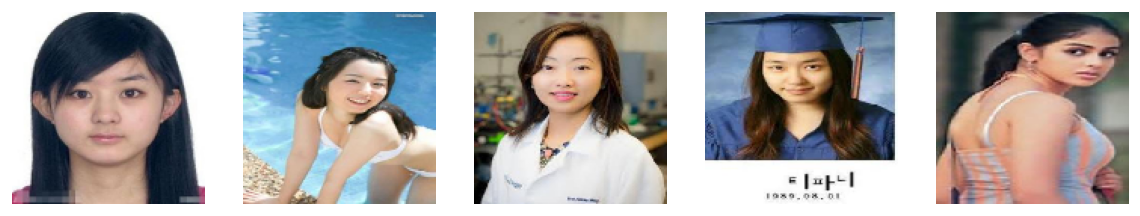

      ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓ YOUNG TO OLD ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓


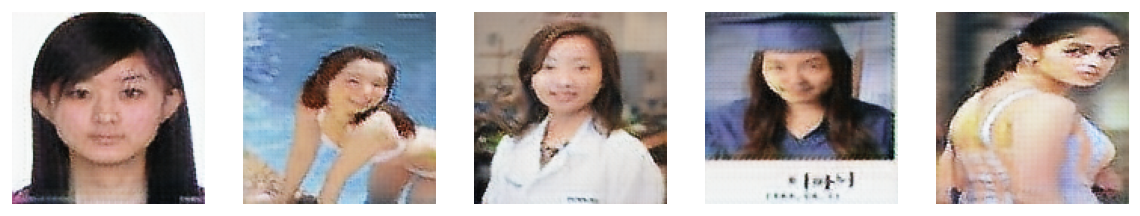

In [ ]:
trainA, trainB = dataset
show_results(g_model_AtoB, trainA, 5, 'YOUNG TO OLD')

1/1 [==============================] - 0s 22ms/step


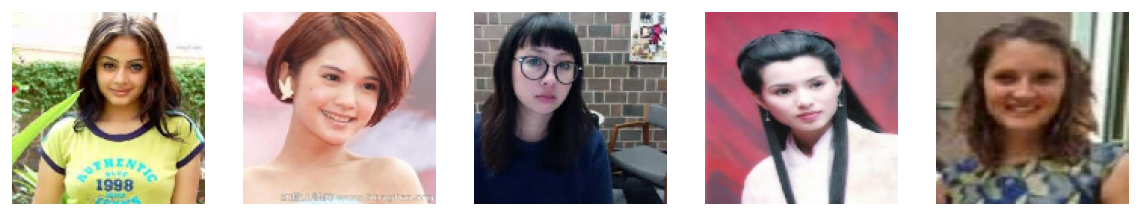

      ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓ YOUNG TO OLD ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓


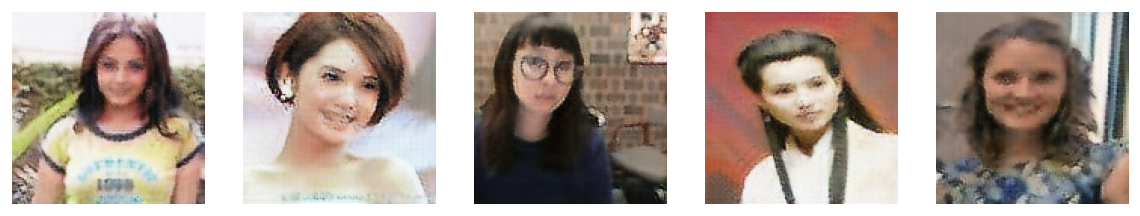

In [ ]:
show_results(g_model_AtoB, trainA, 5, 'YOUNG TO OLD')

1/1 [==============================] - 0s 22ms/step


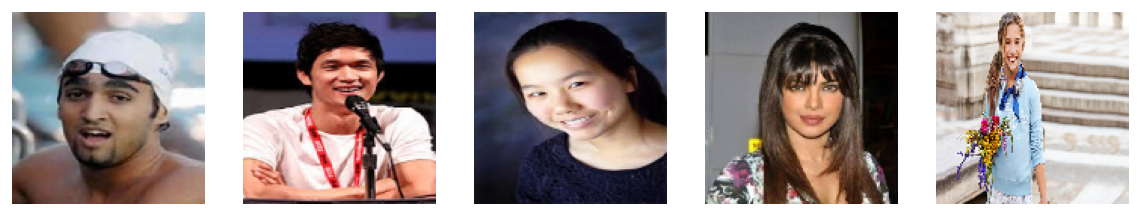

      ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓ YOUNG TO OLD ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓


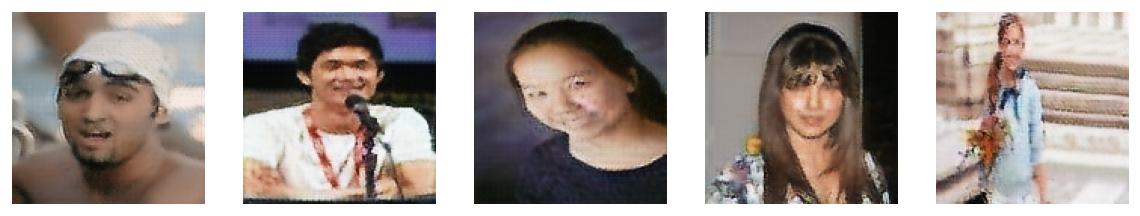

In [ ]:
show_results(g_model_AtoB, trainA, 5, 'YOUNG TO OLD')

## domain B to Domain A generation results : Old to Young

1/1 [==============================] - 1s 688ms/step


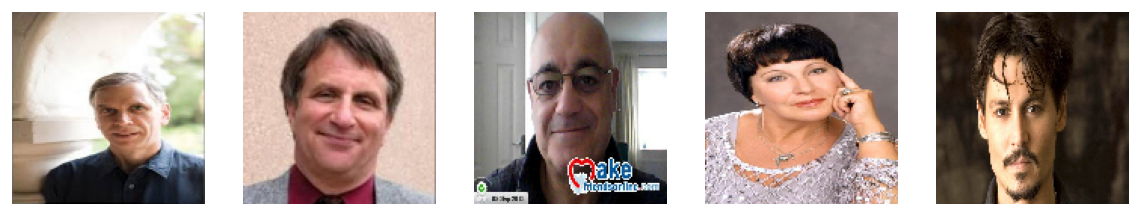

      ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓  Old to Young  ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓


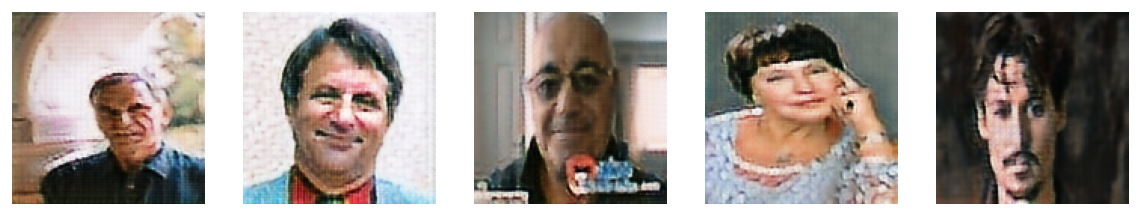

In [ ]:
show_results(g_model_BtoA, trainB ,5, ' Old to Young ')

1/1 [==============================] - 0s 23ms/step


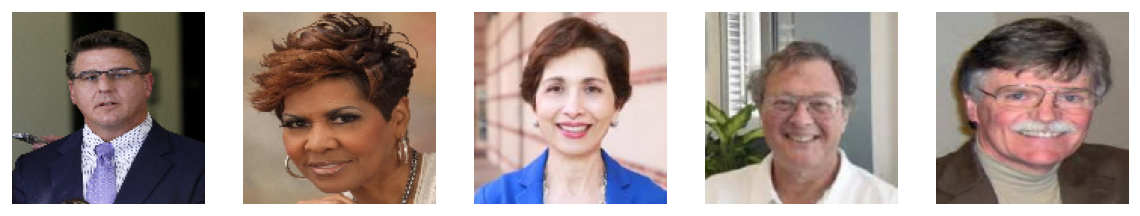

      ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓  Old to Young  ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓


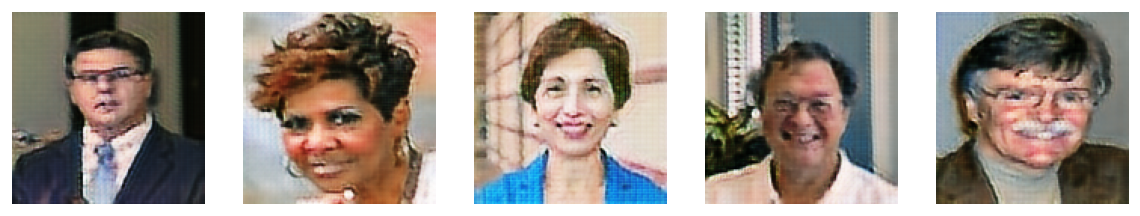

In [ ]:
show_results(g_model_BtoA, trainB ,5, ' Old to Young ')

1/1 [==============================] - 0s 30ms/step


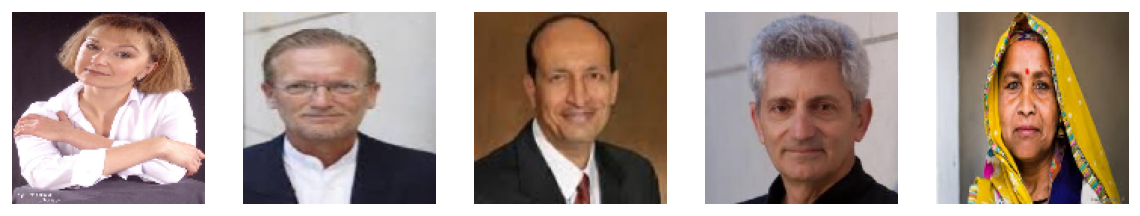

      ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓  Old to Young  ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓


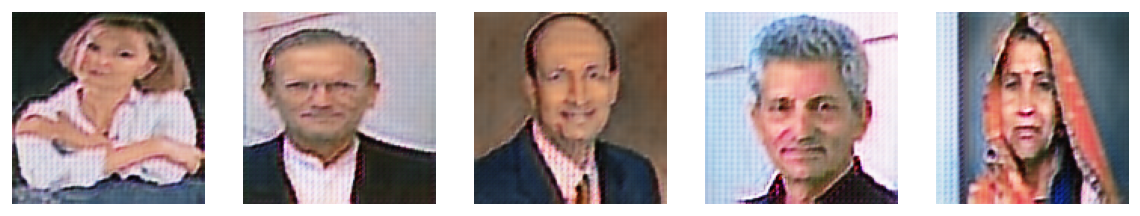

In [ ]:
show_results(g_model_BtoA, trainB ,5, ' Old to Young ')

1/1 [==============================] - 0s 22ms/step


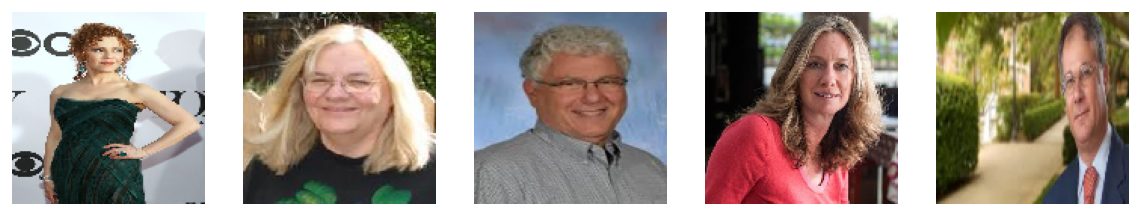

      ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓  Old to Young  ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓


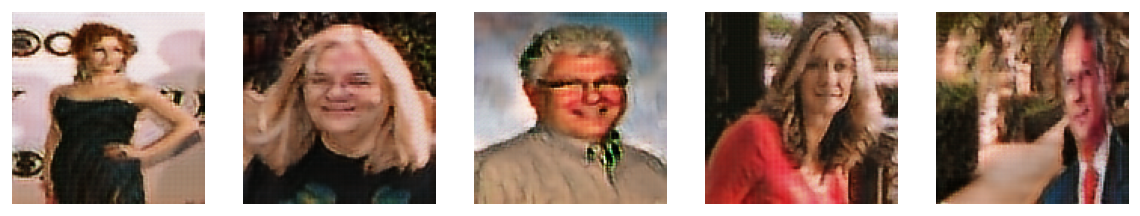

In [ ]:
show_results(g_model_BtoA, trainB ,5, ' Old to Young ')

#### Training the models for more epochs will make the results better, especially for Young to Old Translation . Also we used 128x128 images due to time and compute constraints . Training on the original 200x200 image size would have yielded better results